In [1]:
import torch
import os
import random
import datetime
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
import tqdm

Image 1: CDK_Depict_20_1.png - Image 2: CDK_Depict_33_177_wrong.png
Image 1: CDK_Depict_31_13.png - Image 2: CDK_Depict_7_33_wrong.png
Image 1: CDK_Depict_12_12.png - Image 2: CDK_Depict_29_253_wrong.png
Image 1: CDK_Depict_32_5.png - Image 2: CDK_Depict_22_41_wrong.png
Image 1: CDK_Depict_4_17.png - Image 2: CDK_Depict_22_37_wrong.png
Image 1: CDK_Depict_17_7.png - Image 2: CDK_Depict_29_344_wrong.png
Image 1: CDK_Depict_5_35.png - Image 2: CDK_Depict_12_77_wrong.png
Image 1: CDK_Depict_20_66.png - Image 2: CDK_Depict_27_107_wrong.png
Image 1: CDK_Depict_28_184.png - Image 2: CDK_Depict_29_47_wrong.png
Image 1: CDK_Depict_17_60.png - Image 2: CDK_Depict_17_64_wrong.png


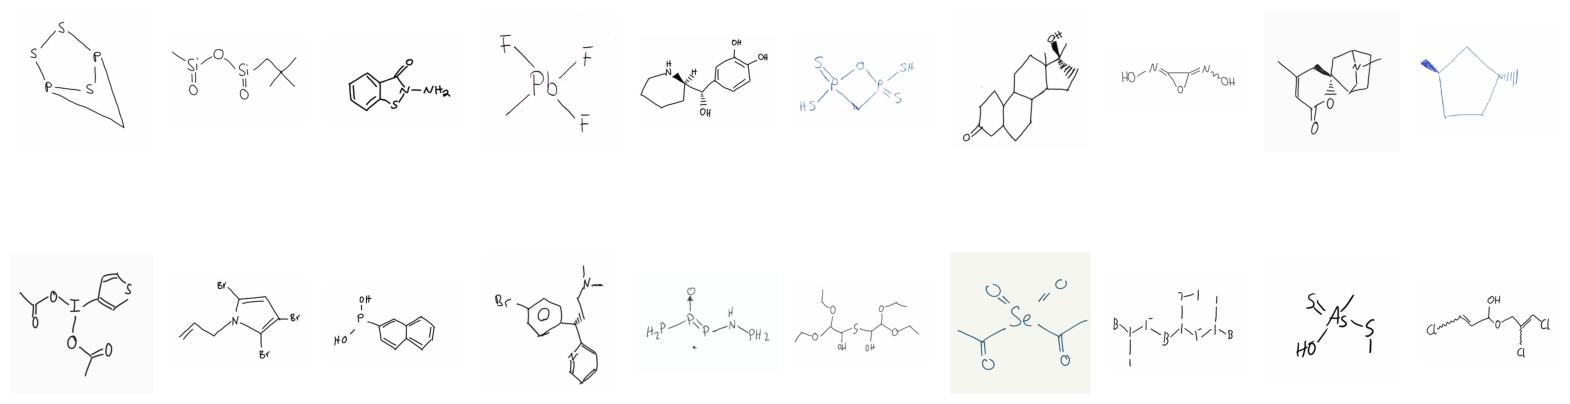

In [3]:
def check_matching_image_counts(root_dir1, root_dir2):
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    return num_images_dir1 == num_images_dir2

def get_matching_indices(root_dir1, root_dir2):
    indices = []
    
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    min_num_images = min(num_images_dir1, num_images_dir2)
    
    for i in range(min_num_images):
        indices.append(i)
        
    return indices

def plot_random_images(root_dir1, root_dir2, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Check if the number of images in each directory matches
    matching_counts = check_matching_image_counts(root_dir1, root_dir2)
    if not matching_counts:
        print("Error: Number of images in each directory does not match.")
        return
    
    # Get matching indices for images from each directory
    indices = get_matching_indices(root_dir1, root_dir2)
    
    # Get random subset of indices
    selected_indices = random.sample(indices, min(num_images, len(indices)))
    
    # Lists to store image names
    img_names1 = []
    img_names2 = []
    
    # Plot images from both directories with the same indices
    for i, idx in enumerate(selected_indices):
        img_name = os.listdir(root_dir1)[idx]
        img_name_wrong = os.listdir(root_dir2)[idx]
        img_names1.append(img_name)
        img_names2.append(img_name_wrong)
        
        img_path_dir1 = os.path.join(root_dir1, img_name)
        img_path_dir2 = os.path.join(root_dir2, img_name_wrong)
        
        img_dir1 = Image.open(img_path_dir1)
        img_dir2 = Image.open(img_path_dir2)
        
        axes[0, i].imshow(img_dir1)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img_dir2)
        axes[1, i].axis('off')
    
    # Print paired image names
    for name1, name2 in zip(img_names1, img_names2):
        print(f"Image 1: {name1} - Image 2: {name2}")
    
    plt.show()

# 경로 설정
root_dir1 = 'DECIMER_data/train/DECIMER_train'
root_dir2 = 'DECIMER_data/train/DECIMER_train_wrong'

# 이미지 플로팅
plot_random_images(root_dir1, root_dir2)

In [4]:
class ImagePairDataset(Dataset):
    def __init__(self, root_dir1, root_dir2, label, transform=None):
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.label = label
        self.transform = transform
        self.samples = []
        
        # 두 디렉토리 안의 이미지 파일을 쌍으로 찾기
        for filename in os.listdir(root_dir1):
            img1_path = os.path.join(root_dir1, filename)
            img2_path = os.path.join(root_dir2, filename)
            if os.path.isfile(img1_path) and os.path.isfile(img2_path):
                # 올바른 쌍인 경우 레이블을 설정
                img1 = self.read_image(img1_path)
                img2 = self.read_image(img2_path)
                self.samples.append((img1, img2, self.label))


    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        return self.samples[idx]

    
    def read_image(self, filepath):
        img = Image.open(filepath).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
class CombinedImagePairDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.total_length = len(dataset1) + len(dataset2)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            img1, img2, label = self.dataset1[idx]
            return img1, img2, label
        else:
            # Adjust the index to fit within the second dataset
            adjusted_idx = idx - len(self.dataset1)
            img1, img2, label = self.dataset2[adjusted_idx]
            return img1, img2, label

In [6]:
class ImageComparisonModel(nn.Module):
    def __init__(self):
        super(ImageComparisonModel, self).__init__()
        
        # Stream 1 for the first image modality
        self.stream1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Stream 2 for the second image modality
        self.stream2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fusion and decision mechanism
        self.comparison = nn.Sequential(
            nn.Linear(16*16*256*2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),  # Binary classification
        )
        
    def forward(self, x1, x2):
        x1 = self.stream1(x1)
        x2 = self.stream2(x2)
        
        # Flatten the features from both streams
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate the features
        x = torch.cat((x1, x2), dim=1)
        
        # Pass through the comparison mechanism
        x = self.comparison(x)
        # Apply softmax to get probabilities
        # x = F.softmax(x, dim=1)
        return x

In [7]:
# # 모델 초기화
combined_model = ImageComparisonModel()

print(combined_model)

ImageComparisonModel(
  (stream1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stream2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNo

In [8]:
# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지 크기를 64x64로 조정
    transforms.ToTensor(),         # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

In [9]:
batch_size = 8

In [10]:
# 경로 설정

chemdraw_train = "DECIMER_data/train/chemdraw_train_from_DECIMER"
chemdraw_test = "DECIMER_data/test/chemdraw_test_from_DECIMER"
chemdraw_valid = "DECIMER_data/valid/chemdraw_valid_from_DECIMER"

chemdraw_train_smlies = "DECIMER_data/train/DECIMER_train"
chemdraw_test_smlies = "DECIMER_data/test/DECIMER_test"
chemdraw_valid_smlies = "DECIMER_data/valid/DECIMER_valid"

chemdraw_train_smlies_wrong = "DECIMER_data/train/DECIMER_train_wrong"
chemdraw_test_smlies_wrong = "DECIMER_data/test/DECIMER_test_wrong"
chemdraw_valid_smlies_wrong = "DECIMER_data/valid/DECIMER_valid_wrong"

In [11]:
# 학습 데이터셋 생성
combine_train_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_train, chemdraw_train_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_train, chemdraw_train_smlies_wrong, 0, transform=transform))
combine_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_test, chemdraw_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_test, chemdraw_test_smlies_wrong, 0, transform=transform))
combine_valid_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies_wrong, 0, transform=transform))

# 데이터로더 생성
train_loader = DataLoader(combine_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combine_test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(combine_valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
print(combine_train_dataset.dataset1.root_dir1)
print(combine_train_dataset.dataset1.root_dir2)

print(combine_test_dataset.dataset1.root_dir1)
print(combine_test_dataset.dataset1.root_dir2)

print(combine_valid_dataset.dataset1.root_dir1)
print(combine_valid_dataset.dataset1.root_dir2)

DECIMER_data/train/chemdraw_train_from_DECIMER
DECIMER_data/train/DECIMER_train
DECIMER_data/test/chemdraw_test_from_DECIMER
DECIMER_data/test/DECIMER_test
DECIMER_data/valid/chemdraw_valid_from_DECIMER
DECIMER_data/valid/DECIMER_valid


In [13]:
# GPU를 사용할 수 있는지 확인합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = combined_model.to(device)

print(device)

cuda


In [14]:
# 학습을 위한 하이퍼파라미터 설정
learning_rate = 1e-5
num_epochs = 200

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(criterion)

BCEWithLogitsLoss()


In [15]:
save_model_path = "Check_Model"

def save_model(model, save_path, acc):
    # 새로운 폴더 생성 (없으면)
    os.makedirs(save_path, exist_ok=True)
    # 현재 시간 가져오기
    now = datetime.datetime.now()
    # 모델 저장
    torch.save(model.state_dict(), os.path.join(save_path, f"model_{now.strftime('%Y%m%d_%H%M%S')}_{acc}.pth"))


def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_accuracy = 0.0
    best_f1 = 0.0
    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []
    best_accuracy_model = None  # 초기화 추가

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # 훈련 데이터로 모델 학습
        for inputs1, inputs2, labels in tqdm.tqdm(train_loader, total=len(train_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # 평균 훈련 손실 계산
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        # 검증 데이터로 모델 평가
        with torch.no_grad():
            for inputs1, inputs2, labels in tqdm.tqdm(valid_loader, total=len(valid_loader)):
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels.float())
                running_valid_loss += loss.item()

                predicted = (outputs > 0).long()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                predictions.extend(predicted.cpu().tolist())
                true_labels.extend(labels.cpu().tolist())

            # 정확도 계산
            accuracy = correct / total
            accuracies.append(accuracy)
            precision = precision_score(true_labels, predictions)
            precisions.append(precision)
            recall = recall_score(true_labels, predictions)
            recalls.append(recall)
            f1 = f1_score(true_labels, predictions)
            f1_scores.append(f1)

        # 평균 검증 손실 계산
        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        # 에포크마다 학습 결과 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.8f}, Valid Loss: {epoch_valid_loss:.8f}, Accuracy: {accuracy:.8f}, Precision: {precision:.8f}, Recall: {recall:.8f}, F1 Score: {f1:.8f}')
        
        # 20번의 에폭이 끝날 때마다 최고 정확도를 확인하고 모델 저장
        if accuracy > best_accuracy:
            best_accuracy = accuracy

        if (epoch + 1) % 20 == 0:
            if save_path:
                # 가장 높은 정확도를 가진 모델 저장
                best_accuracy_index = accuracies.index(max(accuracies))
                best_accuracy_model = model if best_accuracy_index == epoch else best_accuracy_model
                if best_accuracy_model is not None:
                    save_model(best_accuracy_model, save_path, max(accuracies))
                    print("모델이 저장되었습니다.")
            
        # 모델의 손실이 더 낮아졌을 때 저장
        if f1 > best_f1:
            best_f1 = f1
            best_f1_model = model

    return train_losses, valid_losses, accuracies, precisions, recalls, best_accuracy, best_f1, f1_scores


In [ ]:
# 모델 훈련
train_losses, valid_losses, accuracies, precisions, recalls, best_accuracy, best_f1, f1_scores = train_model(combined_model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_model_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 93.33it/s]


Epoch 1/200, Train Loss: 0.54779301, Valid Loss: 0.54362472, Accuracy: 0.98473282, Precision: 1.00000000, Recall: 0.98473282, F1 Score: 0.99230769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 97.11it/s]


Epoch 2/200, Train Loss: 0.49715367, Valid Loss: 0.50169117, Accuracy: 0.99672846, Precision: 1.00000000, Recall: 0.99672846, F1 Score: 0.99836155


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 380/459 [00:22<00:04, 16.64it/s]

In [ ]:
# 학습 결과 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# F1 스코어 시각화
plt.plot(range(1, num_epochs + 1), f1_scores, label='F1 Score', color='green')
plt.plot(range(1, num_epochs + 1), [best_accuracy] * num_epochs, label='Accuracy', color='red')  # best_accuracy를 리스트로 변환하여 모든 에폭에 대해 동일한 값을 가지도록 함
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.title('F1 Score and Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

print(f'Best Accuracy: {best_accuracy}')
print(f'Best F1 Score: {best_f1}')

In [ ]:
print(train_losses, valid_losses, best_accuracy)

In [ ]:
chemdraw_final_test = "data_test/chemdraw_LastTestSet"
chemdraw_final_test_smlies = "data_test/chemdraw_LastTestSet_smlies"
chemdraw_final_test_smlies_wrong = "data_test/chemdraw_LastTestSet_smlies_wrong"

In [ ]:
combine_final_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_final_test, chemdraw_final_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_final_test, chemdraw_final_test_smlies_wrong, 0, transform=transform))

In [ ]:
combine_final_test_loader = DataLoader(combine_final_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs1, inputs2, labels in tqdm.tqdm(test_loader, total=len(test_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            # 이진 분류 문제이므로 0.5를 기준으로 양성(1) 또는 음성(0)으로 분류합니다.
            predicted = (outputs > 0.5).long()
            predictions.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    return predictions, true_labels

In [ ]:
# 모델 평가
predictions, true_labels = evaluate_model(model, test_loader)
predictions_test, true_labels_test = evaluate_model(model, combine_final_test_loader)

# 오차 행렬 계산
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix_test = confusion_matrix(true_labels_test, predictions_test)

print("Confusion Matrix:")
print(conf_matrix)
print("Confusion Matrix Test:")
print(conf_matrix_test)

In [ ]:
def calculate_precision_recall(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]
    true_negatives = conf_matrix[0, 0]
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return precision, recall, true_positives, false_positives, false_negatives, true_negatives

In [ ]:
# 오차 행렬로부터 재현율과 정밀도, 그리고 TP, FP, FN, TN 계산
precision, recall, tp, fp, fn, tn = calculate_precision_recall(conf_matrix)
precision_test, recall_test, tp_test, fp_test, fn_test, tn_test = calculate_precision_recall(conf_matrix_test)

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("\n")
print("True Positives Test:", tp_test)
print("False Positives Test:", fp_test)
print("False Negatives Test:", fn_test)
print("True Negatives Test:", tn_test)

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("\n")
print("Precision Test:", precision_test)
print("Recall Test:", recall_test)

In [ ]:
def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

In [ ]:
# 정밀도, 재현율로부터 F1-score 계산
f1_score = calculate_f1_score(precision, recall)
f1_score_test = calculate_f1_score(precision_test, recall_test)

print("F1-score:", f1_score)
print("\n")
print("F1-score Test:", f1_score_test)